In [1]:
%env CUDA_VISIBLE_DEVICES=-1
import os
import math
import h5py
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import pandas as pd
from tqdm import tqdm

import random
import torch
import torch.utils.data
import torch.nn.functional as F
from collections import defaultdict

Ft = lambda x: torch.fft.ifftshift(torch.fft.fftn(x, dim=(-1, -2)))
IFt = lambda x: torch.fft.ifftshift(torch.fft.ifftn(x, dim=(-1, -2)))


torch.manual_seed(228)
random.seed(228)
np.random.seed(228)

env: CUDA_VISIBLE_DEVICES=-1


In [2]:
!ls /home/a_razumov/small_datasets/singlecoil_val/

file1000000.h5	file1000350.h5	file1000925.h5	file1001365.h5	file1001938.h5
file1000007.h5	file1000356.h5	file1000926.h5	file1001381.h5	file1001955.h5
file1000017.h5	file1000389.h5	file1000932.h5	file1001429.h5	file1001959.h5
file1000026.h5	file1000432.h5	file1000942.h5	file1001440.h5	file1001968.h5
file1000031.h5	file1000464.h5	file1000972.h5	file1001444.h5	file1001977.h5
file1000033.h5	file1000476.h5	file1000976.h5	file1001450.h5	file1001983.h5
file1000041.h5	file1000477.h5	file1000990.h5	file1001458.h5	file1001984.h5
file1000052.h5	file1000480.h5	file1001031.h5	file1001480.h5	file1001995.h5
file1000071.h5	file1000496.h5	file1001057.h5	file1001497.h5	file1001997.h5
file1000073.h5	file1000528.h5	file1001059.h5	file1001499.h5	file1002002.h5
file1000107.h5	file1000537.h5	file1001064.h5	file1001506.h5	file1002007.h5
file1000108.h5	file1000538.h5	file1001077.h5	file1001533.h5	file1002021.h5
file1000114.h5	file1000552.h5	file1001090.h5	file1001557.h5	file1002035.h5
file1000126.h5	file100055

In [12]:
hf = h5py.File('/home/a_razumov/small_datasets/singlecoil_val/file1000769.h5')
hf.keys()

<KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>

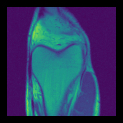

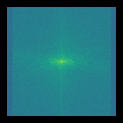

In [13]:
# img = torch.zeros(1, 256, 256)
# img[0, 90:-90, 90:-90] = 1
# img[0, 120:-120, :] = 1
img = torch.from_numpy(hf['reconstruction_esc'][15])[None]
ks = Ft(img)


plt.figure(figsize=(2,2))
plt.imshow(img[0].cpu().abs())
plt.axis('off')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(ks[0].cpu().abs().log())
plt.axis('off')
plt.show()

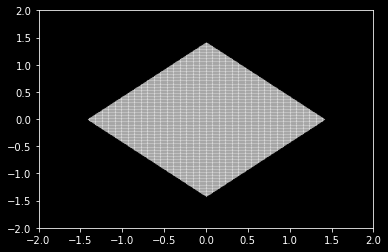

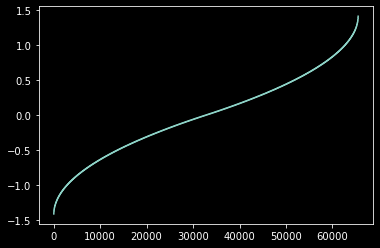

In [14]:
theta = torch.tensor(45).deg2rad()
s = torch.sin(theta)
t = -torch.tan(theta / 2)

grid = torch.stack([torch.linspace(-1, 1, 256), torch.linspace(-1, 1, 256)])
X, Y = torch.meshgrid(grid[0], grid[1])
grid = torch.stack([X.flatten(), Y.flatten()])

R1 = torch.tensor([
    [1, t],
    [0, 1]
])

R2 = torch.tensor([
    [1, 0],
    [s, 1]
])

R3 = torch.tensor([
    [1, t],
    [0, 1]
])

grid = R3 @ R2 @ R1 @ grid

plt.scatter(grid[0], grid[1], s=0.01, c='w')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

plt.plot(grid[1].sort().values)
plt.show()

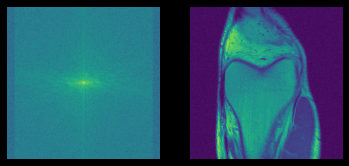

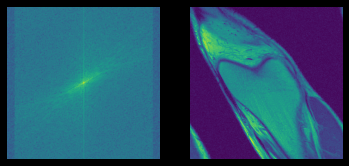

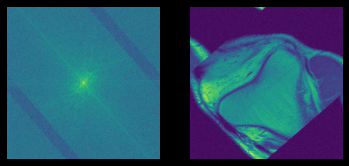

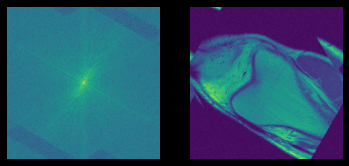

In [15]:
theta = torch.tensor(60).deg2rad()
s = torch.sin(theta)
t = -torch.tan(theta / 2)

grid = torch.stack([torch.arange(-img.shape[1]//2, img.shape[1]//2).float(), torch.arange(-img.shape[2]//2, img.shape[2]//2).float()])
X, Y = torch.meshgrid(grid[0], grid[1])
grid = torch.stack([X.flatten(), Y.flatten()])

R1 = torch.tensor([
    [1, t],
    [0, 1]
])

R2 = torch.tensor([
    [1, 0],
    [s, 1]
])

R3 = torch.tensor([
    [1, t],
    [0, 1]
])


plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(Ft(img.cpu())[0].abs().log())
plt.axis('off')
plt.subplot(122)
plt.imshow(img.cpu()[0].abs())
plt.axis('off')
plt.show()

freq = torch.fft.fftfreq(img.shape[2], 1)
pos = grid[0].reshape(*img.shape[1:])

rimg = torch.fft.ifft(torch.fft.fft(img.cpu()) * (2j * math.pi * t * freq * pos).exp())#.abs()

plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(Ft(rimg.cpu())[0].abs().log())
plt.axis('off')
plt.subplot(122)
plt.imshow(rimg.cpu()[0].abs())
plt.axis('off')
plt.show()

freq = torch.fft.fftfreq(img.shape[1], 1)
pos = grid[0].reshape(*img.shape[1:])

rimg = torch.fft.ifft(torch.fft.fft(rimg.cpu().swapaxes(1,2)) * (2j * math.pi * s * freq * pos).exp()).swapaxes(1,2)#.abs()

plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(Ft(rimg.cpu())[0].abs().log())
plt.axis('off')
plt.subplot(122)
plt.imshow(rimg.cpu()[0].abs())
plt.axis('off')
plt.show()

freq = torch.fft.fftfreq(img.shape[2], 1)
pos = grid[0].reshape(*img.shape[1:])

rimg = torch.fft.ifft(torch.fft.fft(rimg.cpu()) * (2j * math.pi * t * freq * pos).exp())#.abs()

plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(Ft(rimg.cpu())[0].abs().log())
plt.axis('off')
plt.subplot(122)
plt.imshow(rimg.cpu()[0].abs())
plt.axis('off')
plt.show()

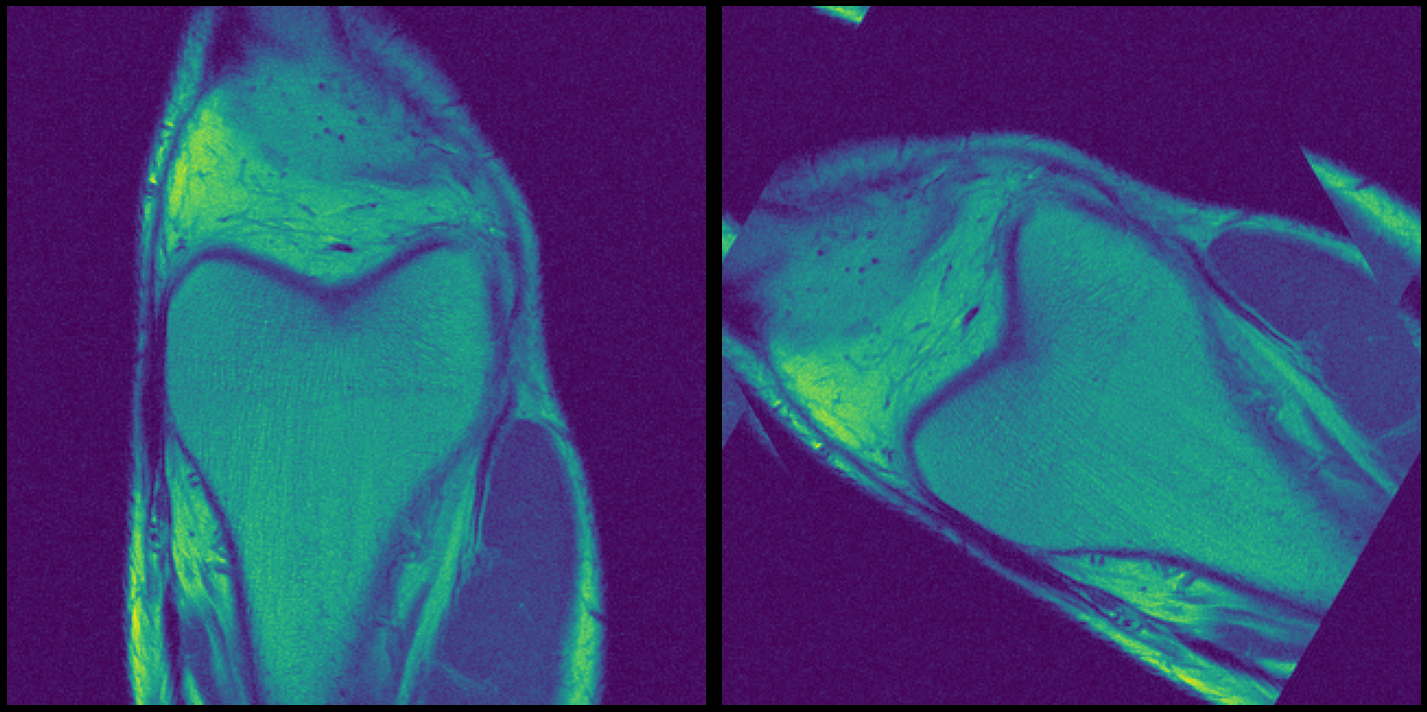

In [16]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img[0].abs())
plt.axis('off')
plt.subplot(122)
plt.imshow(rimg[0].abs())
plt.axis('off')
plt.tight_layout()
plt.show()